- [1 : Importer les librairies](#1)
- [2 : Importer le dataset](#2)
- [3 : Création du X et y](#3)
- [4 : Trouver le modèle plus pertinent](#4)
- - [4-1 : Train_test_split](#4-1)
- - [4-2 : Création des modèles](#4-2)
- [5 : Gridsearch](#5)
- [6 : Treshold](#6)
- [7 : Analyser le résultat](#7)
- [8 : Confirmation du modèle](#8)

In [2]:
!pip install mlflow

     --------------------------------------- 18.1/18.1 MB 29.7 MB/s eta 0:00:00
     ------------------------------------- 224.5/224.5 kB 13.4 MB/s eta 0:00:00
     ---------------------------------------- 148.1/148.1 kB ? eta 0:00:00
     ---------------------------------------- 57.7/57.7 kB ? eta 0:00:00
     ---------------------------------------- 83.5/83.5 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 41.2/41.2 kB ? eta 0:00:00
     --------------------------------------- 21.5/21.5 MB 32.7 MB/s eta 0:00:00
     ------------------------------------- 422.5/422.5 kB 25.8 MB/s eta 0:00:00
     ---------------------------------------- 78.7/78.7 kB ? eta 0:00:00
  Using cached oauthlib-3.2.2-py3-none-any.whl (151 kB)
  Created wheel for databricks-cli: filename=databricks_cli-0.17.7-py3-none-any.whl size=143885 sha256=b8989def6f54af16711c80146af9f7f2b1c048114821f

In [ ]:
!pip install dice-ml

## <a id='1'><center><font color="INDIANRED">1) Importer les librairies</font></center></a>

In [62]:
#On import les librairies
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn import metrics, svm
from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV
#train_test_split sert à séparer le dataset en train et test
#gridsearchCV et randomizedSearchCV servent à trouver les paramètres optimal pour un model en fonction d'un dataset

#import des différents outil pour le scoring
from sklearn.metrics import mean_squared_error, r2_score,classification_report,confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score,precision_recall_curve, roc_auc_score

#import des différents modèles de classification
from sklearn import tree,preprocessing 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgbm

from sklearn.model_selection import learning_curve
#sert à voir si comment le model est entrainé : plus de détail dans le lien si dessous
#https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/
from sklearn.pipeline import make_pipeline
#sert à mettre des objets dans une pipeline qui va itinérer les différents process les uns à la suite
from sklearn.feature_selection import SelectKBest, f_classif 
#SeletKBest sert à séléctionner un nombre de features plus importante
#f_classif sert à faire un test anova sur les features
from sklearn.decomposition import *
from sklearn.preprocessing import *

import warnings #sert à enlever l'affichage des erreurs pas nécéssaire

from collections import Counter
#La classe Counter est une sous-classe de dict qui permet le dénombrement d'objets hachables. 
#Il s'agit d'une collection dans laquelle les éléments sont stockés comme des clés de dictionnaire 
#et leurs nombres d’occurrences respectifs comme leurs valeurs. 
#Ceux-ci peuvent être des entiers relatifs (positifs, négatifs ou nuls). 
#La classe Counter est similaire aux sacs ou aux multiensembles dans d'autres langages.
from imblearn.over_sampling import RandomOverSampler 
#sert à équilibrer les données en rajoutant des données à un dataset déséquilibré
from imblearn.under_sampling import RandomUnderSampler 
#sert à équilibrer les données en enlevant des données à un dataset déséquilibré
import gc #sert à stocker de la mémoire dans des gc
import pickle #sert à importer des models

import mlflow
import mlflow.sklearn
#mlflow.set_tracking_uri('mlrun_store')
#import dice_ml
#from dice_ml.utils import helpers # helper functions

In [63]:
#on va afficher toute les version de nos packages
#pip list

In [64]:
#On ignore les messages rouge d'erreur
warnings.filterwarnings('ignore')

# <a id='2'><center><font color="INDIANRED">2) Importer le dataset</font></center></a>

In [65]:
df_demise = pd.read_csv("df_train.csv")
#df_demise = pd.read_csv("X_sample.csv")

In [47]:
df_demise.shape

(310335, 213)

In [8]:
#si le dataset est mal nettoyé et comporte des valeurs null ou infini ou -infini on remplace ces valeurs par le moyenne
for i in df_demise.columns:
    df_demise[i].replace(np.inf, np.nan, inplace=True)
    df_demise[i].replace(-np.inf, np.nan, inplace=True)
    df_demise[i] = df_demise[i].fillna(df_demise[i].mean())

In [48]:
df_concat = df_demise.copy()

In [3]:
#on affiche la target
df_demise['TARGET'].value_counts()

0    285305
1     25030
Name: TARGET, dtype: int64

In [4]:
# on affiche toute les ligne avec la target 0
df_demise_target_0 = df_demise[df_demise['TARGET'] == 0]
df_demise_target_0

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,DAYS_INSTALLMENT_LATE,PAYMENT_DISCREPANCY,SK_ID_CURR_CNT_BUREAU,SK_ID_CURR_CNT_CRED_CARD,SK_ID_CURR_CNT_POS_CASH,SK_ID_CURR_CNT_INSTALL
1,0,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,-1378.16000,-1385.36000,64754.5860,64754.5860,7.200000,0.00000,4.00000,37.280347,28.0,25.0
2,0,1,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,-754.00000,-761.66670,7096.1550,7096.1550,7.666666,0.00000,2.00000,37.280347,4.0,3.0
3,0,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,-252.25000,-271.62500,62947.0900,62947.0900,19.375000,0.00000,5.55152,6.000000,21.0,16.0
4,0,0,1,0,1,0,121500.0,513000.0,21865.5,513000.0,...,-1028.60610,-1032.24240,12666.4440,12214.0600,3.636364,452.38434,1.00000,37.280347,66.0,66.0
5,0,0,1,0,1,0,99000.0,490495.5,27517.5,454500.0,...,-1263.94290,-1237.88570,27702.9650,27360.5020,-26.057142,342.46158,3.00000,37.280347,83.0,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310329,0,0,0,0,1,0,112500.0,225000.0,22050.0,225000.0,...,-1330.00000,-1332.50000,22771.4080,22771.4080,2.500000,0.00000,13.00000,37.280347,13.0,12.0
310330,0,0,1,0,0,0,157500.0,254700.0,27558.0,225000.0,...,-120.00000,-156.28572,7492.9243,7492.9243,36.285713,0.00000,5.55152,37.280347,9.0,7.0
310331,0,0,0,0,1,0,72000.0,269550.0,12001.5,225000.0,...,-2391.00000,-2393.66670,10069.8670,10069.8670,2.666667,0.00000,5.55152,37.280347,7.0,6.0
310332,0,0,0,0,1,0,153000.0,677664.0,29979.0,585000.0,...,-2373.00000,-2387.71440,4399.7080,4115.9150,14.714286,283.79250,4.00000,37.280347,17.0,14.0


In [49]:
#On prend 5000 lignes avec la target 1
df_demise_target_1 = df_demise[df_demise['TARGET'] == 1]
df_demise_target_1 = df_demise_target_1[:5000]

In [50]:
#On prend 5000 lignes avec la target 0
df_demise_target_0 = df_demise_target_0[:5000]
df_demise_target_0  

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,DAYS_INSTALLMENT_LATE,PAYMENT_DISCREPANCY,SK_ID_CURR_CNT_BUREAU,SK_ID_CURR_CNT_CRED_CARD,SK_ID_CURR_CNT_POS_CASH,SK_ID_CURR_CNT_INSTALL
1,0,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,-1378.1600,-1385.36000,64754.586,64754.5860,7.200000,0.00000,4.00000,37.280347,28.000000,25.000000
2,0,1,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,-754.0000,-761.66670,7096.155,7096.1550,7.666666,0.00000,2.00000,37.280347,4.000000,3.000000
3,0,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,-252.2500,-271.62500,62947.090,62947.0900,19.375000,0.00000,5.55152,6.000000,21.000000,16.000000
4,0,0,1,0,1,0,121500.0,513000.0,21865.5,513000.0,...,-1028.6061,-1032.24240,12666.444,12214.0600,3.636364,452.38434,1.00000,37.280347,66.000000,66.000000
5,0,0,1,0,1,0,99000.0,490495.5,27517.5,454500.0,...,-1263.9429,-1237.88570,27702.965,27360.5020,-26.057142,342.46158,3.00000,37.280347,83.000000,35.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,0,0,1,0,0,0,135000.0,239850.0,22324.5,225000.0,...,-910.6562,-921.94415,18382.863,18743.9430,11.191091,-363.19232,2.00000,37.280347,29.521944,39.838827
5406,0,1,0,1,1,2,121500.0,247500.0,12375.0,247500.0,...,-756.9474,-766.21050,7326.590,7124.1914,9.263158,202.39815,8.00000,37.280347,22.000000,19.000000
5407,0,0,0,0,0,0,166500.0,796500.0,28737.0,796500.0,...,-488.2353,-508.94116,18113.090,18113.0900,20.705883,0.00000,5.55152,37.280347,20.000000,17.000000
5408,0,0,0,0,0,0,180000.0,370107.0,16429.5,319500.0,...,-648.1750,-652.35000,51338.805,62588.8120,4.175000,-11250.00000,14.00000,37.280347,42.000000,40.000000


In [51]:
#on assemble les 2 df qui nous fait un dataset de 10000 lignes avec 5000 lignes de target 0 et 5000 de  target 1
df_concat = pd.concat([df_demise_target_0,df_demise_target_1])
df_concat

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,DAYS_INSTALLMENT_LATE,PAYMENT_DISCREPANCY,SK_ID_CURR_CNT_BUREAU,SK_ID_CURR_CNT_CRED_CARD,SK_ID_CURR_CNT_POS_CASH,SK_ID_CURR_CNT_INSTALL
1,0,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,-1378.1600,-1385.36000,64754.5860,64754.5860,7.200000,0.00000,4.00000,37.280347,28.000000,25.000000
2,0,1,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,-754.0000,-761.66670,7096.1550,7096.1550,7.666666,0.00000,2.00000,37.280347,4.000000,3.000000
3,0,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,-252.2500,-271.62500,62947.0900,62947.0900,19.375000,0.00000,5.55152,6.000000,21.000000,16.000000
4,0,0,1,0,1,0,121500.0,513000.0,21865.5,513000.0,...,-1028.6061,-1032.24240,12666.4440,12214.0600,3.636364,452.38434,1.00000,37.280347,66.000000,66.000000
5,0,0,1,0,1,0,99000.0,490495.5,27517.5,454500.0,...,-1263.9429,-1237.88570,27702.9650,27360.5020,-26.057142,342.46158,3.00000,37.280347,83.000000,35.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62328,1,0,1,1,1,0,90000.0,634482.0,20466.0,454500.0,...,-342.0000,-365.23077,18080.4530,18080.4530,23.230770,0.00000,2.00000,37.280347,15.000000,13.000000
62369,1,0,1,0,0,0,225000.0,817560.0,29493.0,675000.0,...,-1547.0000,-1554.90000,13035.9470,13035.9470,7.900000,0.00000,5.00000,37.280347,11.000000,10.000000
62394,1,1,0,0,0,1,90000.0,180000.0,9000.0,180000.0,...,-792.3684,-802.26320,4904.4243,4904.4243,9.894737,0.00000,6.00000,37.280347,21.000000,19.000000
62396,1,0,0,0,1,1,135000.0,720000.0,36891.0,720000.0,...,-1336.9333,-1341.45340,32446.8240,30214.7460,4.520000,2232.07700,5.55152,37.280347,77.000000,75.000000


In [8]:
#Cette fonction sert à réduire la mémoire utilisé pour les dataframes
#elle consiste à transformer des integer en leur valeurs int minimal
#plus de précision ici : https://qastack.fr/programming/9696660/what-is-the-difference-between-int-int16-int32-and-int64
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [9]:
#On esseye de voir combien de mémoire on à gagné grace a cette fonction
reduce_mem_usage(df_concat)

Memory usage of dataframe is 16.33 MB
Memory usage after optimization is: 3.99 MB
Decreased by 75.6%


,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,DAYS_INSTALLMENT_LATE,PAYMENT_DISCREPANCY,SK_ID_CURR_CNT_BUREAU,SK_ID_CURR_CNT_CRED_CARD,SK_ID_CURR_CNT_POS_CASH,SK_ID_CURR_CNT_INSTALL
1,0,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,-1378.00,-1385.00,64754.585938,64754.585938,7.199219,0.000000,4.000000,37.28125,28.000000,25.00000
2,0,1,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,-754.00,-761.50,7096.154785,7096.154785,7.667969,0.000000,2.000000,37.28125,4.000000,3.00000
3,0,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,-252.25,-271.50,62947.089844,62947.089844,19.375000,0.000000,5.550781,6.00000,21.000000,16.00000
4,0,0,1,0,1,0,121500.0,513000.0,21865.5,513000.0,...,-1029.00,-1032.00,12666.444336,12214.059570,3.636719,452.384338,1.000000,37.28125,66.000000,66.00000
5,0,0,1,0,1,0,99000.0,490495.5,27517.5,454500.0,...,-1264.00,-1238.00,27702.964844,27360.501953,-26.062500,342.461578,3.000000,37.28125,83.000000,35.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62328,1,0,1,1,1,0,90000.0,634482.0,20466.0,454500.0,...,-342.00,-365.25,18080.453125,18080.453125,23.234375,0.000000,2.000000,37.28125,15.000000,13.00000
62369,1,0,1,0,0,0,225000.0,817560.0,29493.0,675000.0,...,-1547.00,-1555.00,13035.947266,13035.947266,7.898438,0.000000,5.000000,37.28125,11.000000,10.00000
62394,1,1,0,0,0,1,90000.0,180000.0,9000.0,180000.0,...,-792.50,-802.50,4904.424316,4904.424316,9.898438,0.000000,6.000000,37.28125,21.000000,19.00000
62396,1,0,0,0,1,1,135000.0,720000.0,36891.0,720000.0,...,-1337.00,-1341.00,32446.824219,30214.746094,4.519531,2232.076904,5.550781,37.28125,77.000000,75.00000


In [10]:
for col in df_concat.columns:
    col_type = df_concat[col].dtype
        
    if col_type != object:
        c_min = df_concat[col].min()
        c_max = df_concat[col].max()
        if str(col_type)[:3] == 'int':
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df_concat[col] = df_concat[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df_concat[col] = df_concat[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df_concat[col] = df_concat[col].astype(np.int32)
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                df_concat[col] = df_concat[col].astype(np.int64)  
        else:
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                df_concat[col] = df_concat[col].astype(np.float16)
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df_concat[col] = df_concat[col].astype(np.float32)
            else:
                df_concat[col] = df_concat[col].astype(np.float64)

In [11]:
#voici le dataset final
df_concat

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,DAYS_INSTALLMENT_LATE,PAYMENT_DISCREPANCY,SK_ID_CURR_CNT_BUREAU,SK_ID_CURR_CNT_CRED_CARD,SK_ID_CURR_CNT_POS_CASH,SK_ID_CURR_CNT_INSTALL
1,0,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,-1378.00,-1385.00,64754.585938,64754.585938,7.199219,0.000000,4.000000,37.28125,28.000000,25.00000
2,0,1,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,-754.00,-761.50,7096.154785,7096.154785,7.667969,0.000000,2.000000,37.28125,4.000000,3.00000
3,0,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,-252.25,-271.50,62947.089844,62947.089844,19.375000,0.000000,5.550781,6.00000,21.000000,16.00000
4,0,0,1,0,1,0,121500.0,513000.0,21865.5,513000.0,...,-1029.00,-1032.00,12666.444336,12214.059570,3.636719,452.384338,1.000000,37.28125,66.000000,66.00000
5,0,0,1,0,1,0,99000.0,490495.5,27517.5,454500.0,...,-1264.00,-1238.00,27702.964844,27360.501953,-26.062500,342.461578,3.000000,37.28125,83.000000,35.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62328,1,0,1,1,1,0,90000.0,634482.0,20466.0,454500.0,...,-342.00,-365.25,18080.453125,18080.453125,23.234375,0.000000,2.000000,37.28125,15.000000,13.00000
62369,1,0,1,0,0,0,225000.0,817560.0,29493.0,675000.0,...,-1547.00,-1555.00,13035.947266,13035.947266,7.898438,0.000000,5.000000,37.28125,11.000000,10.00000
62394,1,1,0,0,0,1,90000.0,180000.0,9000.0,180000.0,...,-792.50,-802.50,4904.424316,4904.424316,9.898438,0.000000,6.000000,37.28125,21.000000,19.00000
62396,1,0,0,0,1,1,135000.0,720000.0,36891.0,720000.0,...,-1337.00,-1341.00,32446.824219,30214.746094,4.519531,2232.076904,5.550781,37.28125,77.000000,75.00000


In [183]:
#Si il y a encore des id on peut les enlever ici
#df_concat = df_concat.drop(["SK_ID_CURR"], axis=1)

In [19]:
# on affiche la mémoire du dataset
start_mem = df_demise.memory_usage().sum() / 1024**2
print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

Memory usage of dataframe is 504.31 MB


On esseye de trouver les bons payeurs et les mauvais payeurs, on se fixe un score de 70%, donc on esseye d'avoir un recall des bons payeurs bien, et une précision des mauvais payeurs bien

## <a id='3'><center><font color="INDIANRED">3) Création du X et y</font></center></a>

In [52]:
X = df_concat.drop("TARGET", axis=1)
y = df_concat["TARGET"]

## Boruta

In [15]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

# Créer un modèle de forêt aléatoire
rf = RandomForestClassifier(n_estimators=100, random_state=1)

# Initialiser Boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)

# Effectuer la sélection des caractéristiques
boruta.fit(X.values, y.values)

# Vérifier les caractéristiques sélectionnées
selected_features = X.columns[boruta.support_].tolist()
print("Caractéristiques sélectionnées :", selected_features)


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	212
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	212
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	212
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	212
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	212
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	212
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	212
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	26
Tentative: 	6
Rejected: 	180
Iteration: 	9 / 100
Confirmed: 	26
Tentative: 	6
Rejected: 	180
Iteration: 	10 / 100
Confirmed: 	26
Tentative: 	6
Rejected: 	180
Iteration: 	11 / 100
Confirmed: 	26
Tentative: 	6
Rejected: 	180
Iteration: 	12 / 100
Confirmed: 	26
Tentative: 	6
Rejected: 	180
Iteration: 	13 / 100
Confirmed: 	26
Tentative: 	6
Rejected: 	180
Iteration: 	14 / 100
Confirmed: 	26
Tentative: 	5
Rejected: 	181
Iteration: 	15 / 100
Confirmed: 	26
Tentative: 	5
Rejected: 	181
Iteration: 	16 / 100
Confirmed: 	26
Tenta

l'algorithme Boruta a confirmé 26 caractéristiques comme importantes pour notre problème spécifique, tandis que 184 caractéristiques ont été rejetées. Cela signifie que l'algorithme considère ces 26 caractéristiques comme ayant une influence significative sur la prédiction de notre Target.

## <a id='4'><center><font color="INDIANRED">4) Trouver le modèle plus pertinent</font></center></a>

### <a id='4-1'><center><font color="steelblue">4-1) Train_test_split</font></center></a>

On sépare les données d'entrainement et de test à hauteur de 67% d'entrainement et 33 % de test

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 0)

In [14]:
df_concat.shape

(10000, 213)

In [22]:
df_concat.to_csv('df_concat.csv')


In [19]:
#ros = RandomOverSampler()
#X_train, y_train = ros.fit_sample(X_train, y_train)
#print('Resampled dataset shape %s' % Counter(X_train))

#rus = RandomUnderSampler()
#X_train, y_train = rus.fit_resample(X_train, y_train)
#print('Resampled dataset shape %s' % Counter(X_train))

### 1 ere simulation Dummy classifier

In [23]:
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score

df_concat = pd.read_csv('./df_concat.csv')
df_concat = df_concat.drop(["Unnamed: 0"], axis=1)
df_concat

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,DAYS_INSTALLMENT_LATE,PAYMENT_DISCREPANCY,SK_ID_CURR_CNT_BUREAU,SK_ID_CURR_CNT_CRED_CARD,SK_ID_CURR_CNT_POS_CASH,SK_ID_CURR_CNT_INSTALL
0,0,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,-1378.0,-1385.0,64754.5860,64754.5860,7.200,0.00000,4.00,37.28,28.00,25.00
1,0,1,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,-754.0,-761.5,7096.1550,7096.1550,7.668,0.00000,2.00,37.28,4.00,3.00
2,0,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,-252.2,-271.5,62947.0900,62947.0900,19.380,0.00000,5.55,6.00,21.00,16.00
3,0,0,1,0,1,0,121500.0,513000.0,21865.5,513000.0,...,-1029.0,-1032.0,12666.4440,12214.0600,3.637,452.38434,1.00,37.28,66.00,66.00
4,0,0,1,0,1,0,99000.0,490495.5,27517.5,454500.0,...,-1264.0,-1238.0,27702.9650,27360.5020,-26.060,342.46158,3.00,37.28,83.00,35.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,0,1,1,1,0,90000.0,634482.0,20466.0,454500.0,...,-342.0,-365.2,18080.4530,18080.4530,23.230,0.00000,2.00,37.28,15.00,13.00
9996,1,0,1,0,0,0,225000.0,817560.0,29493.0,675000.0,...,-1547.0,-1555.0,13035.9470,13035.9470,7.900,0.00000,5.00,37.28,11.00,10.00
9997,1,1,0,0,0,1,90000.0,180000.0,9000.0,180000.0,...,-792.5,-802.5,4904.4243,4904.4243,9.900,0.00000,6.00,37.28,21.00,19.00
9998,1,0,0,0,1,1,135000.0,720000.0,36891.0,720000.0,...,-1337.0,-1341.0,32446.8240,30214.7460,4.520,2232.07700,5.55,37.28,77.00,75.00


In [24]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_concat.drop(columns=['TARGET']), df_concat['TARGET'], test_size=0.3,stratify=y, random_state=42)

# Instantiate the dummy classifier and fit it to the training data
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)

# Make predictions on the test data
y_pred = dummy.predict(X_test)

# Calculate the accuracy and recall scores of the dummy classifier
accuracy = accuracy_score(y_test, y_pred)

print(f'Dummy classifier accuracy: {accuracy}')


Dummy classifier accuracy: 0.4876666666666667


#### Pas d’overfiting sur mon modèle

### <a id='4-2'><center><font color="steelblue">4-2) Création des modèles</font></center></a>

In [25]:
def evaluate(model):
    #On entraine le modèle
    model.fit(X_train,y_train)
    #On fait les prédictions
    pred = model.predict(X_test)
    
    # Calculate accuracy and recall
    acc = accuracy_score(y_test, pred)
    recall = recall_score(y_test, pred)

    # Log accuracy and recall to MLflow
    mlflow.log_metric("Accuracy", acc)
    mlflow.log_metric("Recall", recall)
    
    #on affiche la matrice de confusion
    print(confusion_matrix(y_test,pred))
    #On affiche toute les valeurs de metrics pour la classification
    print(classification_report(y_test,pred))
    #On affiche l'AUC
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    print('AUC : %0.6f' %roc_auc)
       

In [56]:
!pip install hyperopt

     ---------------------------------------- 1.6/1.6 MB 16.9 MB/s eta 0:00:00
     ------------------------------------- 200.5/200.5 kB 11.9 MB/s eta 0:00:00


In [57]:
import hyperopt

In [61]:
from hyperopt import fmin, tpe, hp
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# Définir la fonction objectif
def objective(params):
    # Créer un classificateur AdaBoost avec les hyperparamètres donnés
    clf = AdaBoostClassifier(**params)

    # Effectuer une validation croisée avec le classificateur
    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')

    # Retourner l'accuracy moyenne négative (Hyperopt minimise la fonction objectif)
    return -scores.mean()

# Définir l'espace de recherche pour les hyperparamètres
space = {
    'n_estimators': hp.choice('n_estimators', range(50, 500)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 1.0),
    'algorithm': hp.choice('algorithm', ['SAMME', 'SAMME.R'])
}

# Exécuter l'optimisation des hyperparamètres avec Hyperopt (10 itérations)
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10)

# Afficher les meilleurs hyperparamètres trouvés
print("Meilleurs hyperparamètres:", best)

# Créer un classificateur AdaBoost avec les meilleurs hyperparamètres
best_clf = AdaBoostClassifier(**best)

# Ajuster le classificateur sur l'ensemble des données d'entraînement
best_clf.fit(X, y)

# Faire des prédictions sur les données de test
y_pred = best_clf.predict(X_test)

# Calculer et afficher l'accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


100%|██████████| 10/10 [28:49<00:00, 172.96s/trial, best loss: -0.6923]           
Meilleurs hyperparamètres: {'algorithm': 1, 'learning_rate': 0.48193187254889597, 'n_estimators': 382}


InvalidParameterError: The 'algorithm' parameter of AdaBoostClassifier must be a str among {'SAMME', 'SAMME.R'}. Got 1 instead.

In [26]:
from sklearn.model_selection import cross_val_score

In [27]:
#On créer une pipeline, avec 2 polynomial, un test anova sur le Kbest et avec une séléction de 12 features
#mettre dans l'estimateur dans un seul processe, make_pipeline mettre les séquence que l'on  va appliquer
Pipe = make_pipeline(SelectKBest(f_classif,k=12))

In [28]:
#On définit les modèles
random_forest_classifier = make_pipeline(Pipe,StandardScaler(), RandomForestClassifier(random_state=0))
adaboost = make_pipeline(Pipe, AdaBoostClassifier(random_state=0))
SVM = make_pipeline(Pipe,StandardScaler(),SVC(random_state=0, kernel='linear', probability=True))
KNN = make_pipeline(Pipe,StandardScaler(),KNeighborsClassifier(algorithm='ball_tree', metric='euclidean'))
regressionlogistique = make_pipeline(Pipe, LogisticRegression(solver = 'liblinear'))
dtree = make_pipeline(Pipe, tree.DecisionTreeClassifier(criterion = 'gini', random_state = 0))
XGboostcla = make_pipeline(Pipe,xgb.XGBClassifier())
#lgbm = makepipeline(Pipe,lgb.LGBMClassifier(boosting = 'dart', application = 'binary',
#    'learning_rate': 0.02,
#    'min_data_in_leaf': 30,
#    'num_leaves': 34,
#    'max_depth': 8,
#    'feature_fraction': 0.9497036,
#    'scale_pos_weight': 2,
#    'drop_rate': 0.02,
#    'reg_alpha': 0.041545473,
#    'reg_lambda': 0.0735294,
#    'min_split_gain': 0.0222415,
#    'min_child_weight': 39.3259775))

In [29]:
models_pipe = { 'random_forest_classifier' : random_forest_classifier,
                'adaboost' : adaboost,
                'SVM' : SVM,
                'KNN' : KNN,
                'regressionlogistique' : regressionlogistique,
                'dtree' : dtree,
                'XGboostcla' : XGboostcla}
 #               'lgbm' : lgbm}

2023/07/09 00:59:37 INFO mlflow.tracking.fluent: Experiment with name 'MLTest' does not exist. Creating a new experiment.
2023/07/09 00:59:38 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



random_forest_classifier
[[1053  484]
 [ 505  958]]
              precision    recall  f1-score   support

           0       0.68      0.69      0.68      1537
           1       0.66      0.65      0.66      1463

    accuracy                           0.67      3000
   macro avg       0.67      0.67      0.67      3000
weighted avg       0.67      0.67      0.67      3000

AUC : 0.725184


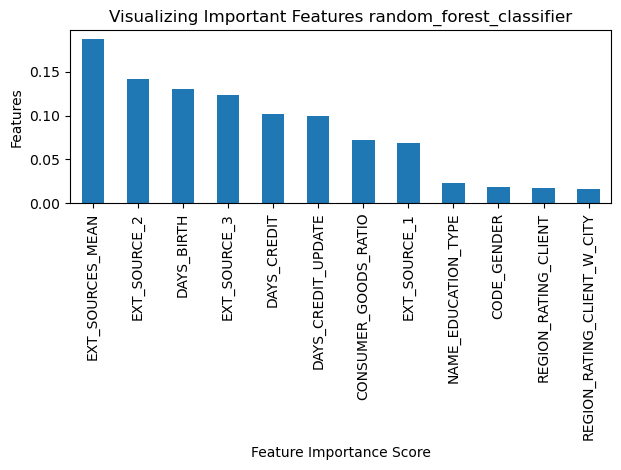

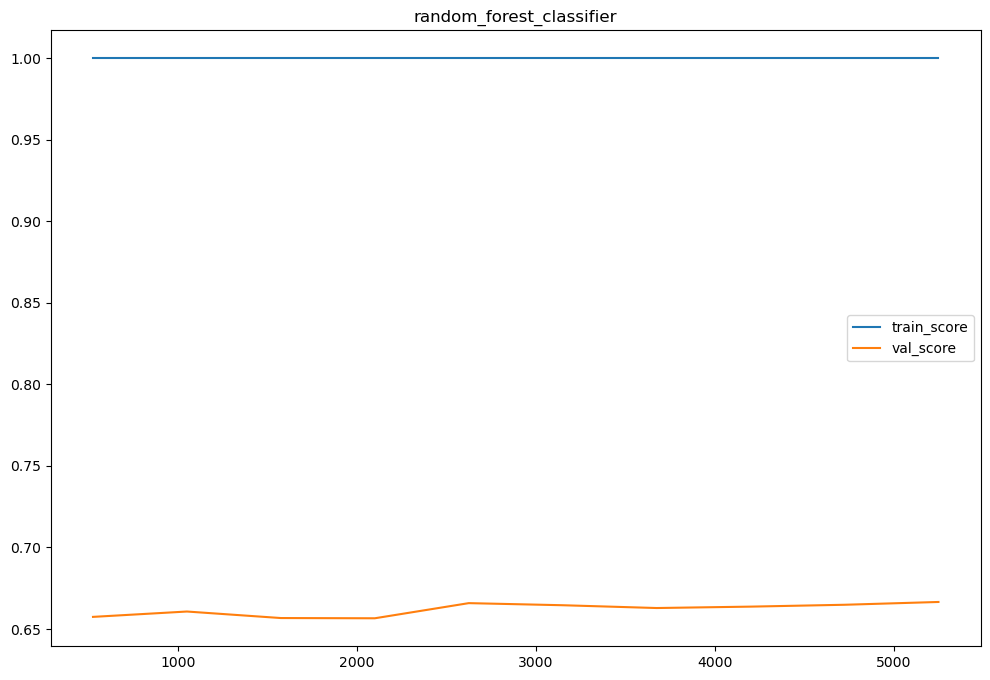


____________________________________________________________________________________

adaboost
[[1045  492]
 [ 488  975]]
              precision    recall  f1-score   support

           0       0.68      0.68      0.68      1537
           1       0.66      0.67      0.67      1463

    accuracy                           0.67      3000
   macro avg       0.67      0.67      0.67      3000
weighted avg       0.67      0.67      0.67      3000

AUC : 0.740861


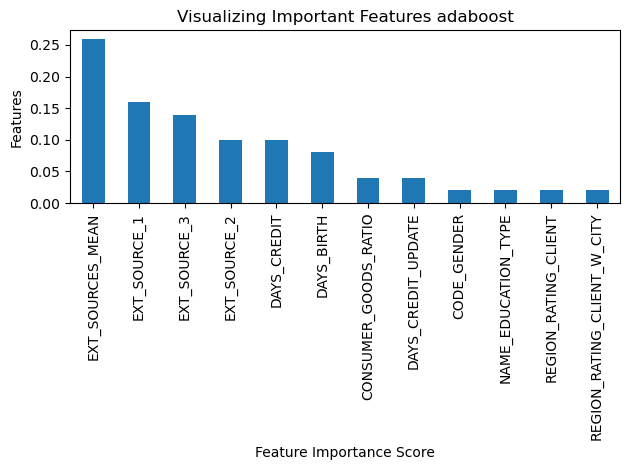

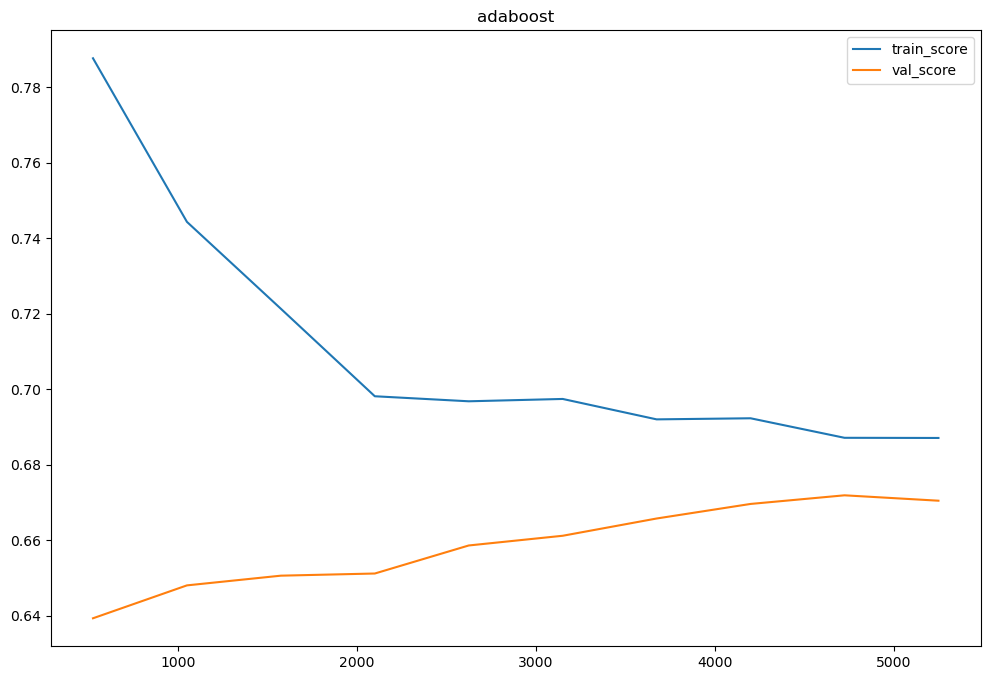


____________________________________________________________________________________

SVM
[[1052  485]
 [ 498  965]]
              precision    recall  f1-score   support

           0       0.68      0.68      0.68      1537
           1       0.67      0.66      0.66      1463

    accuracy                           0.67      3000
   macro avg       0.67      0.67      0.67      3000
weighted avg       0.67      0.67      0.67      3000

AUC : 0.737267


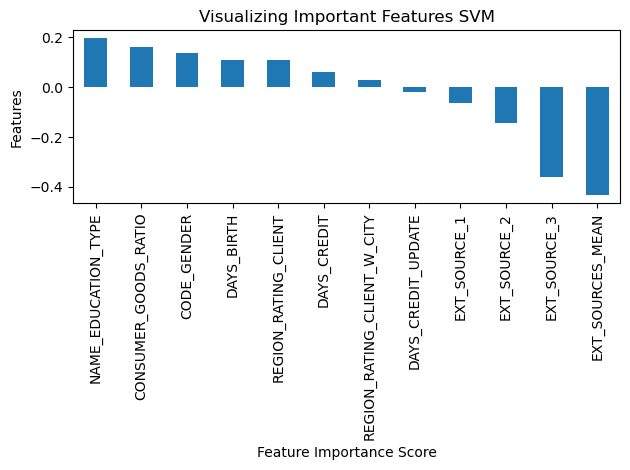

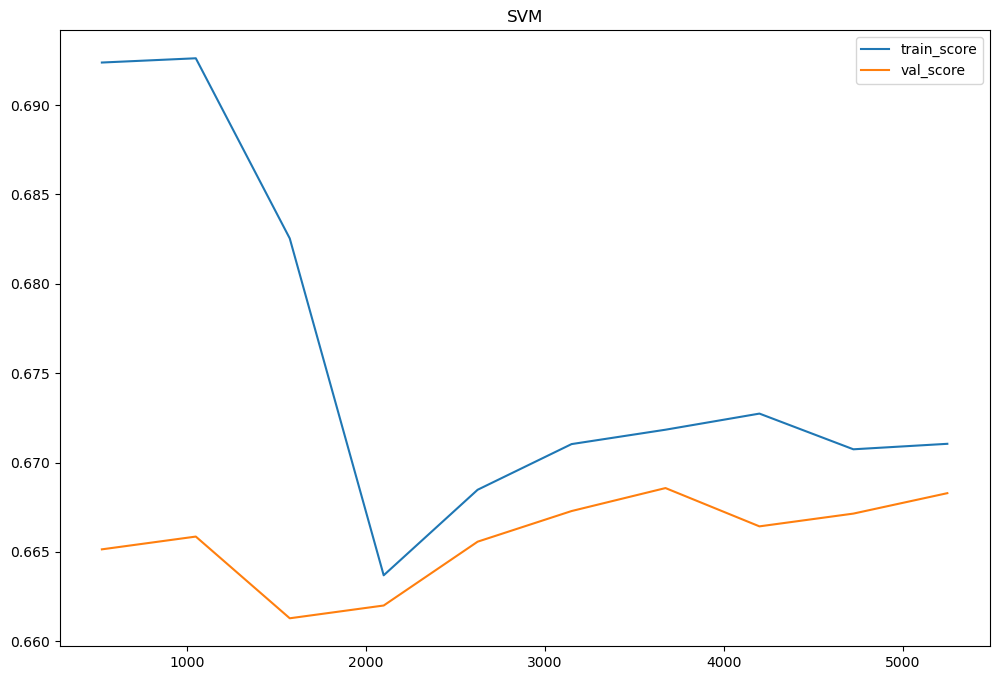


____________________________________________________________________________________

KNN
[[994 543]
 [534 929]]
              precision    recall  f1-score   support

           0       0.65      0.65      0.65      1537
           1       0.63      0.63      0.63      1463

    accuracy                           0.64      3000
   macro avg       0.64      0.64      0.64      3000
weighted avg       0.64      0.64      0.64      3000

AUC : 0.682813
Le model K-nearest neighbors ne dispose pas de visualisation sur les features importance

____________________________________________________________________________________

regressionlogistique
[[1028  509]
 [ 492  971]]
              precision    recall  f1-score   support

           0       0.68      0.67      0.67      1537
           1       0.66      0.66      0.66      1463

    accuracy                           0.67      3000
   macro avg       0.67      0.67      0.67      3000
weighted avg       0.67      0.67      0.67     

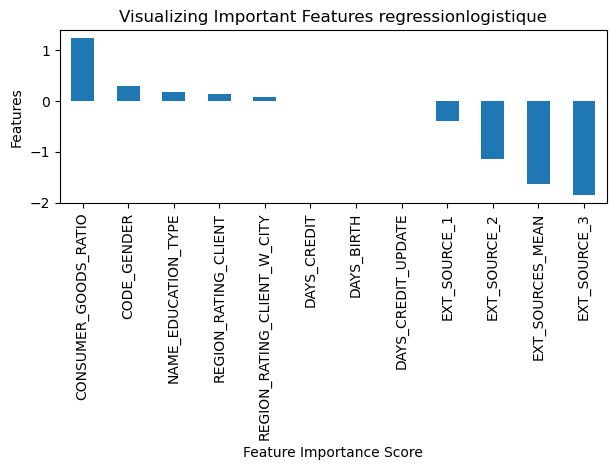

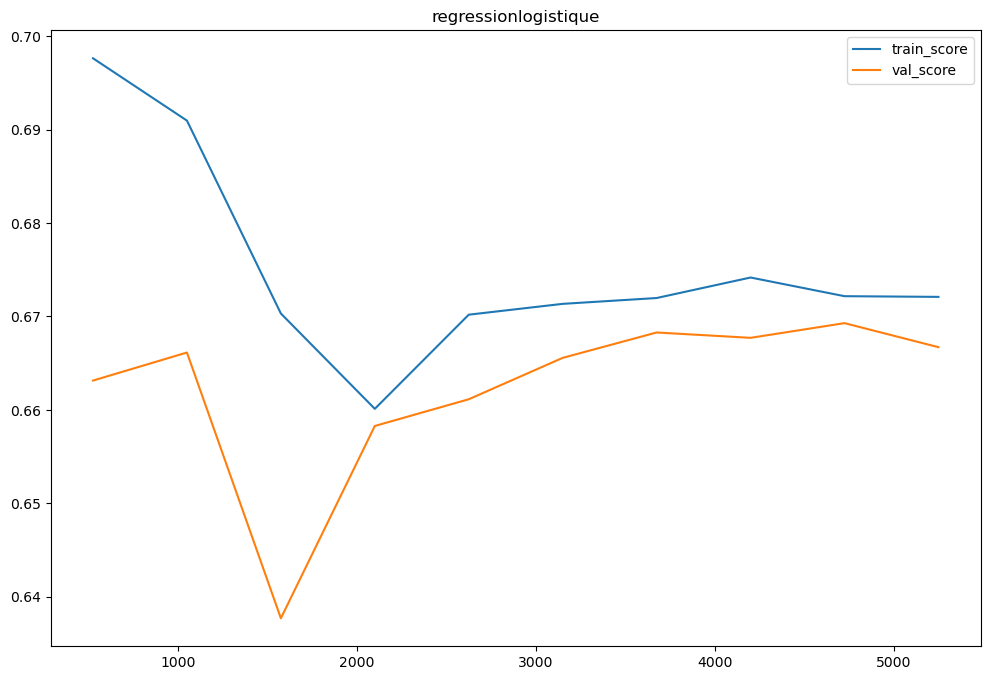


____________________________________________________________________________________

dtree
[[906 631]
 [654 809]]
              precision    recall  f1-score   support

           0       0.58      0.59      0.59      1537
           1       0.56      0.55      0.56      1463

    accuracy                           0.57      3000
   macro avg       0.57      0.57      0.57      3000
weighted avg       0.57      0.57      0.57      3000

AUC : 0.571217


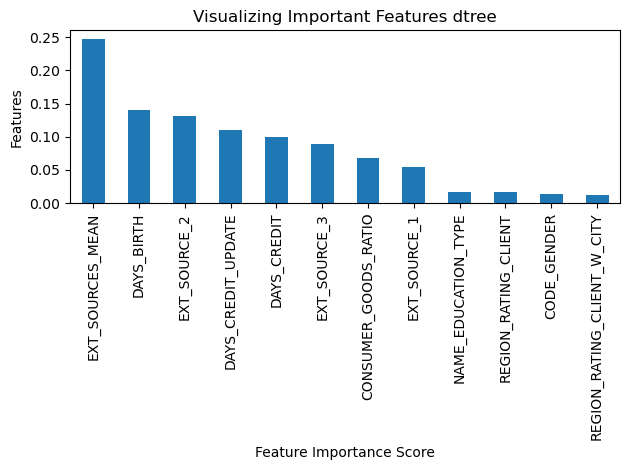

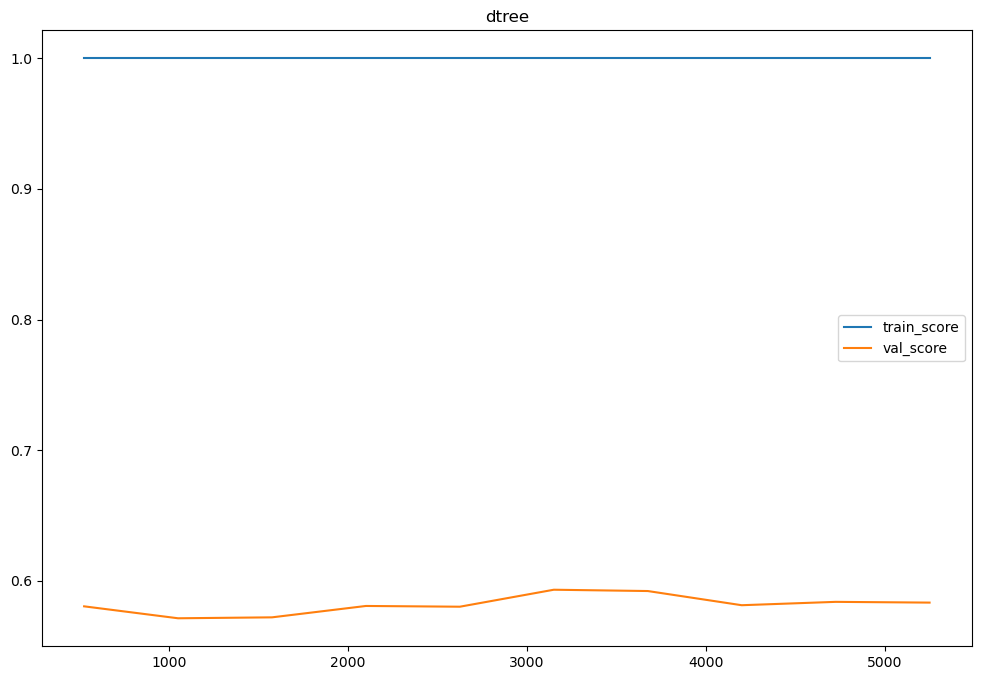


____________________________________________________________________________________

XGboostcla
[[999 538]
 [466 997]]
              precision    recall  f1-score   support

           0       0.68      0.65      0.67      1537
           1       0.65      0.68      0.67      1463

    accuracy                           0.67      3000
   macro avg       0.67      0.67      0.67      3000
weighted avg       0.67      0.67      0.67      3000

AUC : 0.721663


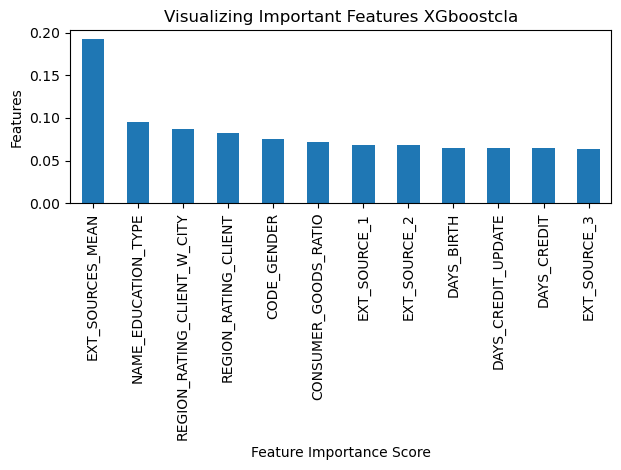

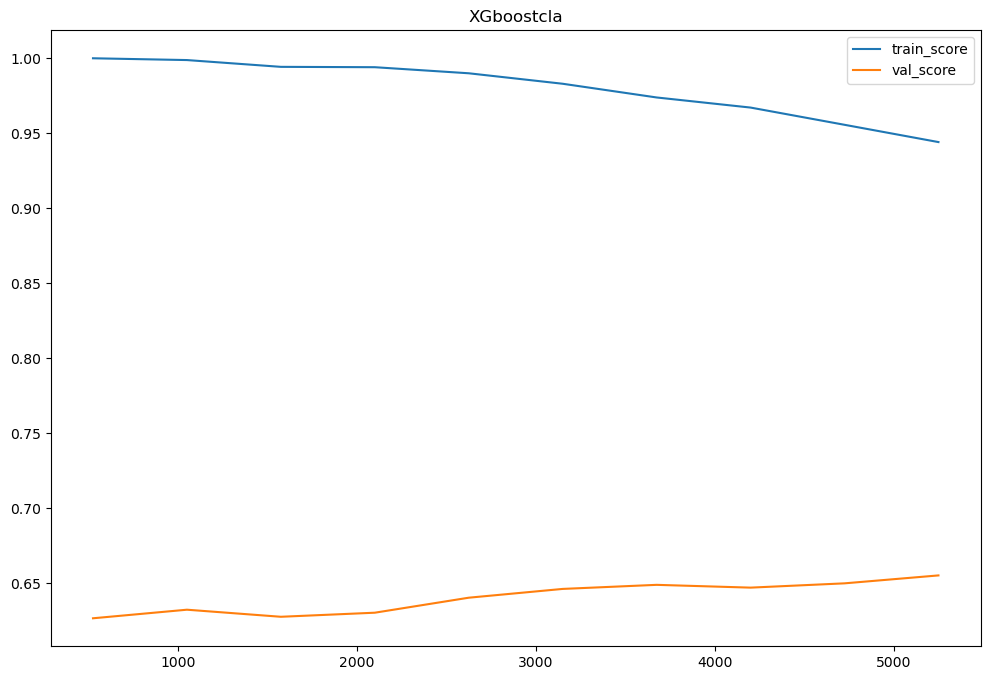


____________________________________________________________________________________



In [30]:
#boucle pour faire les modèles
mlflow.set_experiment("MLTest")
for name,model in models_pipe.items() : 
    with mlflow.start_run():
        
        
        model.fit(X_train, y_train)

        # Get predictions
        y_pred = model.predict(X_test)

        # Calculate accuracy and recall
        acc = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)

        # Log accuracy and recall to MLflow
        mlflow.log_metric("Accuracy", acc)
        mlflow.log_metric("Recall", recall)
        print(name)
        evaluate(model)
        
        #on importe le modèle
        if name == 'random_forest_classifier' or name =='KNN' or name =='SVM':
            pickle.dump(model, open('model_' + name + '.pkl', 'wb'))
        else:
            pickle.dump(model, open('model_' + name + '.pkl', 'wb'))
        
        if name =='KNN':
            print('Le model K-nearest neighbors ne dispose pas de visualisation sur les features importance')
        else:
            #on récupere toute les colonnes crée par le polynomial feature
            #random_X_train = model.steps[0][1][0].get_feature_names(X_train.columns)
            random_X_train = X_train.columns
            #on récupére le numéro des colonnes séléctionner par le selectKbest
            cols = model.steps[0][1][0].get_support(indices=True)

            if name == 'random_forest_classifier': 
                #on va créer un dictionnaire qui va créer un dataframe avec l'importance des features de chaque colonne
                dict_of_list_of_features = dict(pd.Series(model.steps[2][1].feature_importances_))
                #on récupere la valeur des features importances
                list_features = model.steps[2][1].feature_importances_
            elif name=='SVM':
                dict_of_list_of_features = dict(pd.Series(model.steps[2][1].coef_[0]))
                list_features = model.steps[2][1].coef_[0]
            elif name=='regressionlogistique':
                dict_of_list_of_features = dict(pd.Series(model.steps[1][1].coef_[0]))
                list_features = model.steps[1][1].coef_[0]
            else:
                dict_of_list_of_features = dict(pd.Series(model.steps[1][1].feature_importances_))
                list_features = model.steps[1][1].feature_importances_
            #on créer une liste vide
            name_colonne_random_features = []
            #on va faire une boucle pour ajouter tout les numéros de colonne du selectKbest à la liste vide
            for i in cols:
                name_colonne_random_features.append(random_X_train[i])
            #on transforme la valeur des features importances en liste
            list_features = list(list_features)
            #on créer un dataset avec la valeur des features importances
            data_robert = pd.DataFrame(data=list_features)
            #on pivot le dataframe
            data_robert = data_robert.T
            #on rajoute le nom des colonnes au dataset
            data_robert.columns=[name_colonne_random_features]
            if name == 'random_forest_classifier': 
                #on trie le dataset avec la feature la plus importante en haut
                feature_imp = pd.Series(model.steps[2][1].feature_importances_,index=data_robert.columns).sort_values(ascending=False)
            elif name=='SVM':
                feature_imp = pd.Series(model.steps[2][1].coef_[0],index=data_robert.columns).sort_values(ascending=False)
            elif name=='regressionlogistique':
                feature_imp = pd.Series(model.steps[1][1].coef_[0],index=data_robert.columns).sort_values(ascending=False)
            else:
                feature_imp = pd.Series(model.steps[1][1].feature_importances_,index=data_robert.columns).sort_values(ascending=False)
            
            feature_imp.to_csv(f"{name}_feature_importance_df.csv", index=False)
            df_feat = feature_imp.reset_index()
            #on affiche les features importances dans un plot
            #sns.barplot(x=df_feat[0], y=df_feat['level_0'])
            df_feat.columns = ['feature', 'importance']
            df_feat.plot(kind="bar", x='feature', y='importance', legend=None)
            #feature_importance_df.plot(kind="bar", x="feature", y="importance", legend=None)
            plt.xlabel('Feature Importance Score')
            plt.ylabel('Features')
            plt.title("Visualizing Important Features " + name)            
            plt.tight_layout()
            plt.savefig(f"{name}_feature_importance_graph.png")
            plt.show()
            #Learning curve avec cross validation de 4
            N, train_score,val_score = learning_curve(model, X_train, y_train, cv = 4, train_sizes = np.linspace(0.1,1,10), scoring = 'accuracy')
    
            #on l'affiche dans un plot
            plt.figure(figsize=(12,8))
            plt.plot(N, train_score.mean(axis=1),label='train_score')
            plt.plot(N, val_score.mean(axis=1),label='val_score')
            plt.title(f'{name}')
            plt.legend()
            plt.savefig(f"{name}_learning_curve.png")
            plt.show()
            mlflow.log_artifact(f"{name}_feature_importance_df.csv")
            mlflow.log_artifact(f"{name}_feature_importance_graph.png")
            mlflow.log_artifact(f"{name}_learning_curve.png")
            mlflow.sklearn.log_model(model, "model")
            mlflow.end_run()
            
                
        #On affiche une ligne por séparer chaque model
        print("\n____________________________________________________________________________________\n")  
        

random_forest_classifier
[[1092  565]
 [ 553 1090]]
              precision    recall  f1-score   support

           0       0.66      0.66      0.66      1657
           1       0.66      0.66      0.66      1643

    accuracy                           0.66      3300
   macro avg       0.66      0.66      0.66      3300
weighted avg       0.66      0.66      0.66      3300

AUC : 0.724916


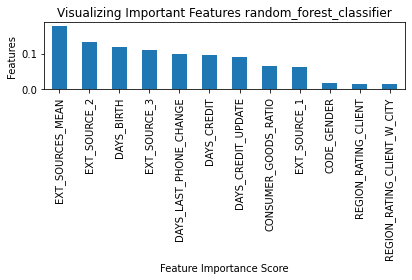

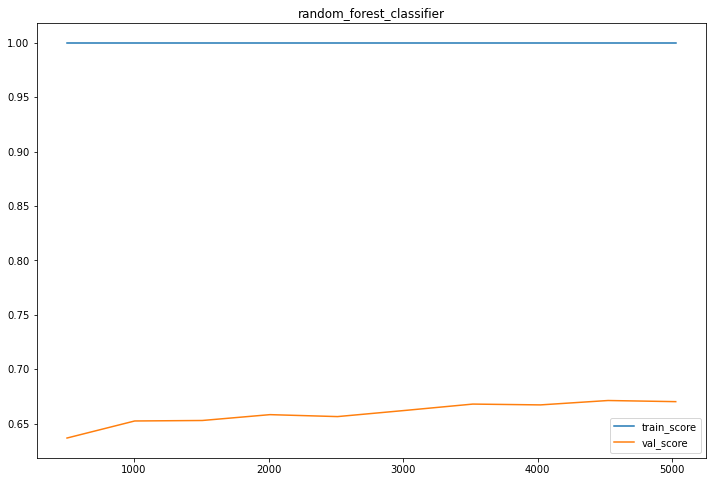


____________________________________________________________________________________

adaboost
[[1106  551]
 [ 552 1091]]
              precision    recall  f1-score   support

           0       0.67      0.67      0.67      1657
           1       0.66      0.66      0.66      1643

    accuracy                           0.67      3300
   macro avg       0.67      0.67      0.67      3300
weighted avg       0.67      0.67      0.67      3300

AUC : 0.728565


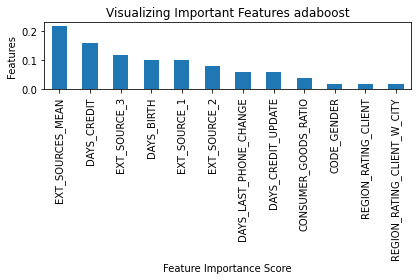

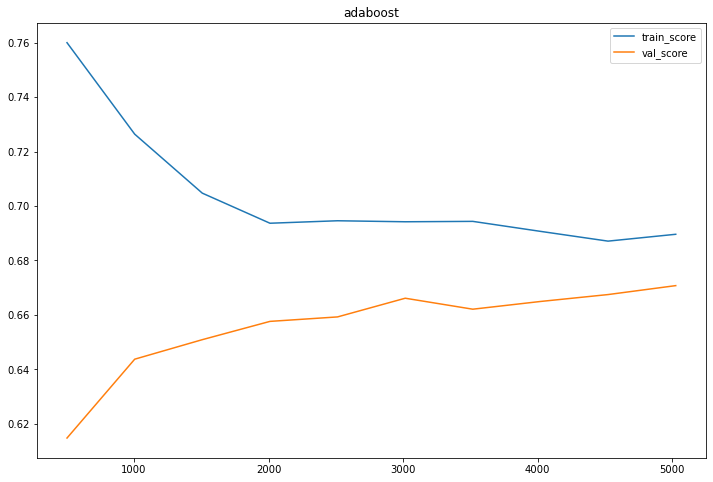


____________________________________________________________________________________

SVM
[[1109  548]
 [ 539 1104]]
              precision    recall  f1-score   support

           0       0.67      0.67      0.67      1657
           1       0.67      0.67      0.67      1643

    accuracy                           0.67      3300
   macro avg       0.67      0.67      0.67      3300
weighted avg       0.67      0.67      0.67      3300

AUC : 0.726721


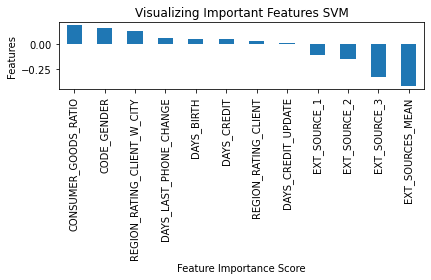

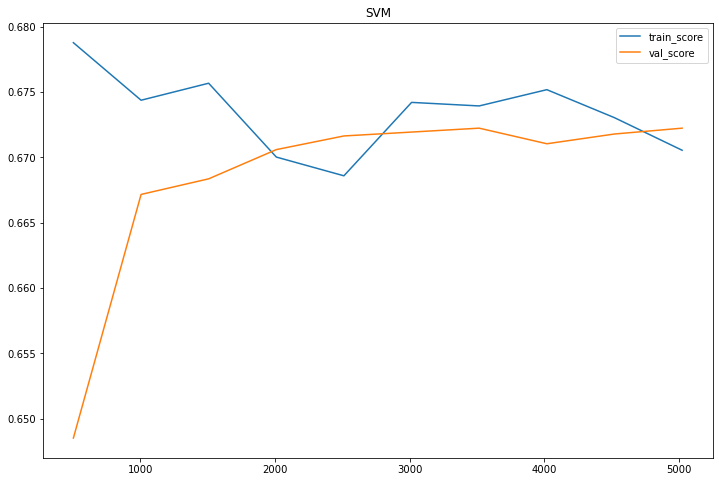


____________________________________________________________________________________

KNN
[[1051  606]
 [ 592 1051]]
              precision    recall  f1-score   support

           0       0.64      0.63      0.64      1657
           1       0.63      0.64      0.64      1643

    accuracy                           0.64      3300
   macro avg       0.64      0.64      0.64      3300
weighted avg       0.64      0.64      0.64      3300

AUC : 0.669598
Le model K-nearest neighbors ne dispose pas de visualisation sur les features importance

____________________________________________________________________________________

regressionlogistique
[[1105  552]
 [ 541 1102]]
              precision    recall  f1-score   support

           0       0.67      0.67      0.67      1657
           1       0.67      0.67      0.67      1643

    accuracy                           0.67      3300
   macro avg       0.67      0.67      0.67      3300
weighted avg       0.67      0.67      0.67 

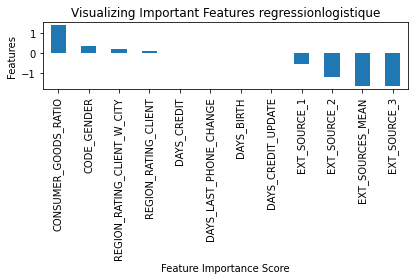

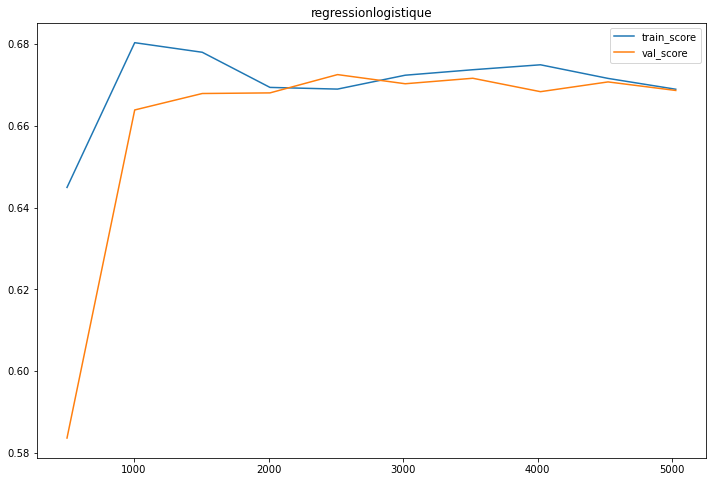


____________________________________________________________________________________

dtree
[[984 673]
 [701 942]]
              precision    recall  f1-score   support

           0       0.58      0.59      0.59      1657
           1       0.58      0.57      0.58      1643

    accuracy                           0.58      3300
   macro avg       0.58      0.58      0.58      3300
weighted avg       0.58      0.58      0.58      3300

AUC : 0.583593


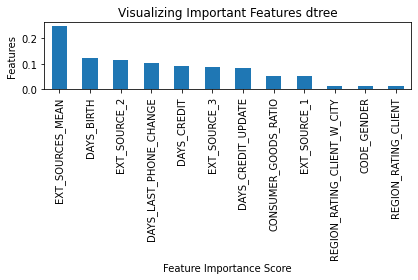

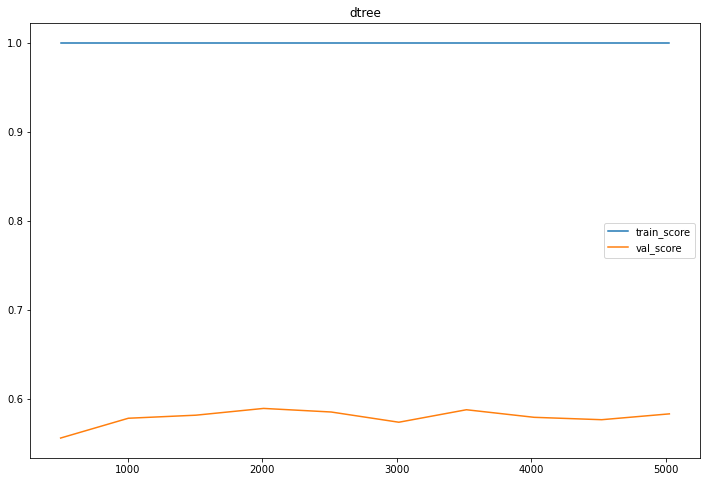


____________________________________________________________________________________

XGboostcla
[[1072  585]
 [ 554 1089]]
              precision    recall  f1-score   support

           0       0.66      0.65      0.65      1657
           1       0.65      0.66      0.66      1643

    accuracy                           0.65      3300
   macro avg       0.65      0.65      0.65      3300
weighted avg       0.65      0.65      0.65      3300

AUC : 0.708457


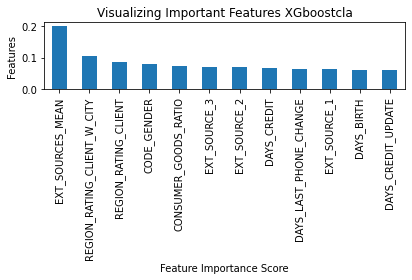

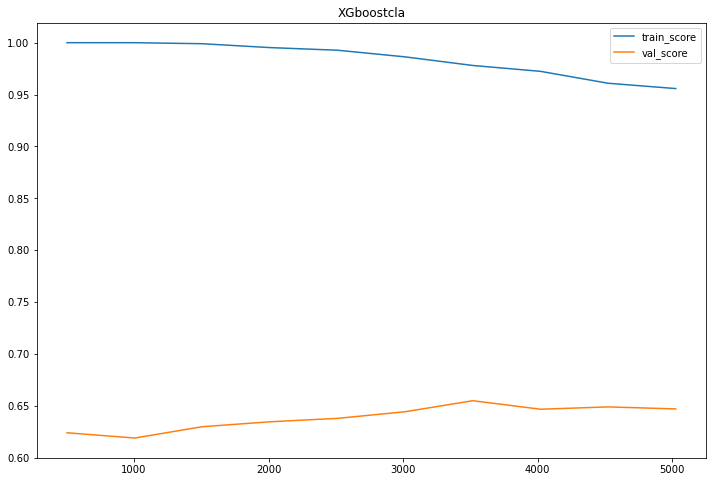


____________________________________________________________________________________



In [196]:
#boucle pour faire les modèles
mlflow.set_experiment("MLTest")
for name,model in models_pipe.items() : 
    with mlflow.start_run():
        
        
        model.fit(X_train, y_train)

        # Get predictions
        y_pred = model.predict(X_test)

        # Calculate accuracy and recall
        acc = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)

        # Log accuracy and recall to MLflow
        mlflow.log_metric("Accuracy", acc)
        mlflow.log_metric("Recall", recall)
        print(name)
        evaluate(model)
        
        #on importe le modèle
        if name == 'random_forest_classifier' or name =='KNN' or name =='SVM':
            pickle.dump(model, open('model_' + name + '.pkl', 'wb'))
        else:
            pickle.dump(model, open('model_' + name + '.pkl', 'wb'))
        
        if name =='KNN':
            print('Le model K-nearest neighbors ne dispose pas de visualisation sur les features importance')
        else:
            #on récupere toute les colonnes crée par le polynomial feature
            #random_X_train = model.steps[0][1][0].get_feature_names(X_train.columns)
            random_X_train = X_train.columns
            #on récupére le numéro des colonnes séléctionner par le selectKbest
            cols = model.steps[0][1][0].get_support(indices=True)

            if name == 'random_forest_classifier': 
                #on va créer un dictionnaire qui va créer un dataframe avec l'importance des features de chaque colonne
                dict_of_list_of_features = dict(pd.Series(model.steps[2][1].feature_importances_))
                #on récupere la valeur des features importances
                list_features = model.steps[2][1].feature_importances_
            elif name=='SVM':
                dict_of_list_of_features = dict(pd.Series(model.steps[2][1].coef_[0]))
                list_features = model.steps[2][1].coef_[0]
            elif name=='regressionlogistique':
                dict_of_list_of_features = dict(pd.Series(model.steps[1][1].coef_[0]))
                list_features = model.steps[1][1].coef_[0]
            else:
                dict_of_list_of_features = dict(pd.Series(model.steps[1][1].feature_importances_))
                list_features = model.steps[1][1].feature_importances_
            #on créer une liste vide
            name_colonne_random_features = []
            #on va faire une boucle pour ajouter tout les numéros de colonne du selectKbest à la liste vide
            for i in cols:
                name_colonne_random_features.append(random_X_train[i])
            #on transforme la valeur des features importances en liste
            list_features = list(list_features)
            #on créer un dataset avec la valeur des features importances
            data_robert = pd.DataFrame(data=list_features)
            #on pivot le dataframe
            data_robert = data_robert.T
            #on rajoute le nom des colonnes au dataset
            data_robert.columns=[name_colonne_random_features]
            if name == 'random_forest_classifier': 
                #on trie le dataset avec la feature la plus importante en haut
                feature_imp = pd.Series(model.steps[2][1].feature_importances_,index=data_robert.columns).sort_values(ascending=False)
            elif name=='SVM':
                feature_imp = pd.Series(model.steps[2][1].coef_[0],index=data_robert.columns).sort_values(ascending=False)
            elif name=='regressionlogistique':
                feature_imp = pd.Series(model.steps[1][1].coef_[0],index=data_robert.columns).sort_values(ascending=False)
            else:
                feature_imp = pd.Series(model.steps[1][1].feature_importances_,index=data_robert.columns).sort_values(ascending=False)
            
            feature_imp.to_csv(f"{name}_feature_importance_df.csv", index=False)
            df_feat = feature_imp.reset_index()
            #on affiche les features importances dans un plot
            #sns.barplot(x=df_feat[0], y=df_feat['level_0'])
            df_feat.columns = ['feature', 'importance']
            df_feat.plot(kind="bar", x='feature', y='importance', legend=None)
            #feature_importance_df.plot(kind="bar", x="feature", y="importance", legend=None)
            plt.xlabel('Feature Importance Score')
            plt.ylabel('Features')
            plt.title("Visualizing Important Features " + name)            
            plt.tight_layout()
            plt.savefig(f"{name}_feature_importance_graph.png")
            plt.show()
            #Learning curve avec cross validation de 4
            N, train_score,val_score = learning_curve(model, X_train, y_train, cv = 4, train_sizes = np.linspace(0.1,1,10), scoring = 'accuracy')
    
            #on l'affiche dans un plot
            plt.figure(figsize=(12,8))
            plt.plot(N, train_score.mean(axis=1),label='train_score')
            plt.plot(N, val_score.mean(axis=1),label='val_score')
            plt.title(f'{name}')
            plt.legend()
            plt.savefig(f"{name}_learning_curve.png")
            plt.show()
            mlflow.log_artifact(f"{name}_feature_importance_df.csv")
            mlflow.log_artifact(f"{name}_feature_importance_graph.png")
            mlflow.log_artifact(f"{name}_learning_curve.png")
            mlflow.sklearn.log_model(model, "model")
            mlflow.end_run()
            
                
        #On affiche une ligne por séparer chaque model
        print("\n____________________________________________________________________________________\n")  
        

## <a id='5'><center><font color="INDIANRED">5)RandomizedSearch</font></center></a>

GridSearch a pris tellement de temps, donc j'ai décidé d'utiliser RandomizedSearch à la place. J'ai fait un autre notebook pour RandomizedSearch et dans celui-ci on peut voir que les paramètres optimaux sont {'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 565}

In [192]:
#df_concat = df_concat.drop(["Unnamed: 0"], axis=1)
df_concat

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,DAYS_INSTALLMENT_LATE,PAYMENT_DISCREPANCY,SK_ID_CURR_CNT_BUREAU,SK_ID_CURR_CNT_CRED_CARD,SK_ID_CURR_CNT_POS_CASH,SK_ID_CURR_CNT_INSTALL
1,0,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,-1378.00,-1385.00,64754.585938,64754.585938,7.199219,0.000000,4.000000,37.28125,28.000000,25.00000
2,0,1,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,-754.00,-761.50,7096.154785,7096.154785,7.667969,0.000000,2.000000,37.28125,4.000000,3.00000
3,0,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,-252.25,-271.50,62947.085938,62947.085938,19.375000,0.000000,5.550781,6.00000,21.000000,16.00000
4,0,0,1,0,1,0,121500.0,513000.0,21865.5,513000.0,...,-1029.00,-1032.00,12666.444336,12214.060547,3.636719,452.384308,1.000000,37.28125,66.000000,66.00000
5,0,0,1,0,1,0,99000.0,490495.5,27517.5,454500.0,...,-1264.00,-1238.00,27702.964844,27360.501953,-26.062500,342.461578,3.000000,37.28125,83.000000,35.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62328,1,0,1,1,1,0,90000.0,634482.0,20466.0,454500.0,...,-342.00,-365.25,18080.453125,18080.453125,23.234375,0.000000,2.000000,37.28125,15.000000,13.00000
62369,1,0,1,0,0,0,225000.0,817560.0,29493.0,675000.0,...,-1547.00,-1555.00,13035.946289,13035.946289,7.898438,0.000000,5.000000,37.28125,11.000000,10.00000
62394,1,1,0,0,0,1,90000.0,180000.0,9000.0,180000.0,...,-792.50,-802.50,4904.424316,4904.424316,9.898438,0.000000,6.000000,37.28125,21.000000,19.00000
62396,1,0,0,0,1,1,135000.0,720000.0,36891.0,720000.0,...,-1337.00,-1341.00,32446.824219,30214.748047,4.519531,2232.076904,5.550781,37.28125,77.000000,75.00000


In [31]:
X = df_concat.drop("TARGET", axis=1)
y = df_concat["TARGET"]

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0)

In [34]:
from sklearn.ensemble import AdaBoostClassifier

# Create AdaBoost classifier with the optimal hyperparameters
ada = AdaBoostClassifier(algorithm='SAMME.R', learning_rate=0.1, n_estimators=565)

# Train the classifier on your training data
ada.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=0.1, n_estimators=565)

In [35]:
from sklearn.metrics import classification_report

# assuming you have trained your model and made predictions on some test data
y_pred = ada.predict(X_test)

# assuming y_test is the true labels for the test data
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.71      0.70      1657
           1       0.70      0.69      0.70      1643

    accuracy                           0.70      3300
   macro avg       0.70      0.70      0.70      3300
weighted avg       0.70      0.70      0.70      3300



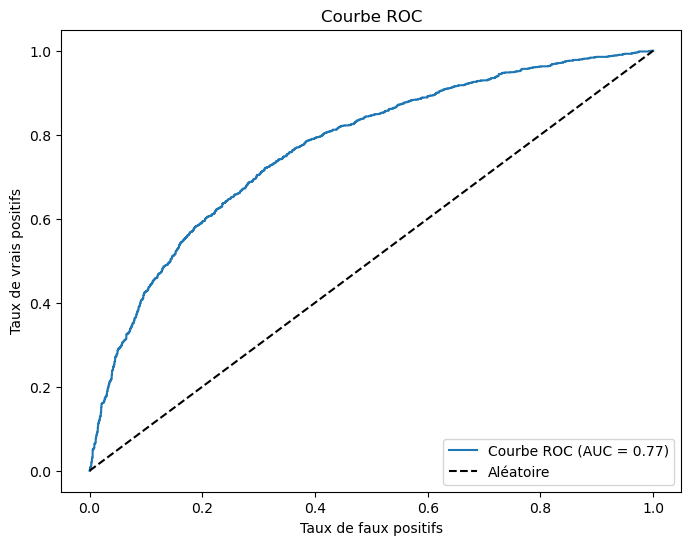

In [37]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Obtenez les probabilités de prédiction du modèle
y_pred_proba = ada.predict_proba(X_test)[:, 1]

# Calculez le taux de faux positifs, le taux de vrais positifs et les seuils de classification
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculez l'AUC (Area Under the Curve)
auc = roc_auc_score(y_test, y_pred_proba)

# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Courbe ROC (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--', label='Aléatoire')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()


In [11]:
from sklearn.metrics import confusion_matrix

y_pred = ada.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[1176  481]
 [ 505 1138]]


Cette matrice de confusion montre les résultats de la classification binaire. Dans ce cas, il y a 1176 vrais négatifs (la prédiction et la réalité sont toutes les deux négatives), 481 faux positifs (la prédiction est positive mais la réalité est négative), 505 faux négatifs (la prédiction est négative mais la réalité est positive) et 1138 vrais positifs (la prédiction et la réalité sont toutes les deux positives). La somme des vrais positifs et des vrais négatifs donne le nombre total de prédictions correctes, tandis que la somme des faux positifs et des faux négatifs donne le nombre total de prédictions incorrectes. La matrice de confusion est un outil utile pour évaluer les performances d'un modèle de classification binaire.

# Lime

In [ ]:
from lime import lime_tabular

In [ ]:
# Lime - Explication des prédictions
explainer = lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns.values, class_names=['No Diabetes', 'Diabetes'])
lime_explanation = explainer.explain_instance(X_test.iloc[0].values, model.predict_proba, num_features=len(X.columns))
lime_explanation.show_in_notebook()

# Shap

In [ ]:
import shap

In [ ]:
# SHAP - Importance des caractéristiques
explainer_shap = shap.TreeExplainer(model)
shap_values = explainer_shap.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test, plot_type='bar')

## <a id='6'><center><font color="INDIANRED">6)Fonction coût</font></center></a>


In [38]:
from sklearn.metrics import make_scorer, confusion_matrix

# Définition de la fonction de coût métier
def custom_cost(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return 10 * fn + fp

# Création du score métier
scorer = make_scorer(custom_cost, greater_is_better=False)



In [41]:
# Définir les modèles et les hyperparamètres à optimiser
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 5, 10]
}

# Créer l'objet GridSearchCV avec le score métier et les autres métriques
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, scoring={'CustomCost': scorer, 'Accuracy': 'accuracy', 'AUC': 'roc_auc'}, refit='CustomCost')

# Effectuer la recherche des meilleurs hyperparamètres
grid_search.fit(X, y)

# Afficher les meilleurs hyperparamètres et les scores correspondants
print("Meilleurs hyperparamètres : ", grid_search.best_params_)
print("Score métier : ", grid_search.best_score_)  # Le score est inversé, donc on le multiplie par -1 pour l'afficher correctement
print("Accuracy : ", grid_search.best_score_['Accuracy'])
print("AUC : ", grid_search.best_score_['AUC'])


search = GridSearchCV(estimator=ada, param_grid=search_grid, scoring={'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Score': make_scorer(custom_cost)}, n_jobs=-1, cv=crossvalidation)


Meilleurs hyperparamètres :  {'max_depth': 10, 'n_estimators': 200}
Score métier :  3530.2


IndexError: invalid index to scalar variable.

In [43]:
search = GridSearchCV(estimator=ada, param_grid=search_grid, scoring={'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Score': make_scorer(custom_cost)}, n_jobs=-1, cv=crossvalidation)


NameError: name 'search_grid' is not defined

In [42]:
print("Score métier : ", grid_search.best_score_)  # Le score est inversé, donc on le multiplie par -1 pour l'afficher correctement
print("Accuracy : ", grid_search.best_score_['Accuracy'])
print("AUC : ", grid_search.best_score_['AUC'])


Score métier :  -3530.2


IndexError: invalid index to scalar variable.

## <a id='7'><center><font color="INDIANRED">6)Treshold</font></center></a>

In [36]:
from sklearn.metrics import precision_recall_curve

# Get predicted probabilities for test data
y_pred_proba = ada.predict_proba(X_test)[:, 1]

# Calculate precision, recall, and thresholds
precision, recall, threshold = precision_recall_curve(y_test, y_pred_proba)

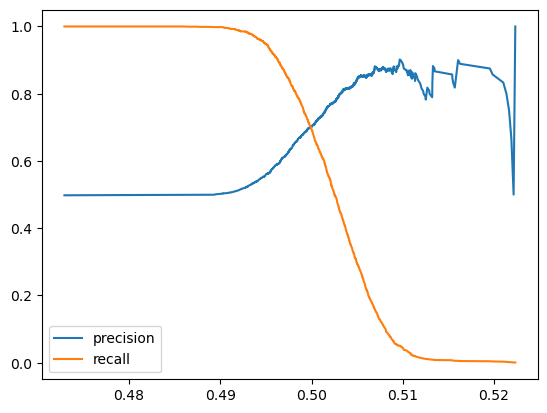

In [37]:
plt.plot(threshold,precision[:-1], label="precision")
plt.plot(threshold,recall[:-1], label="recall")
plt.legend() 

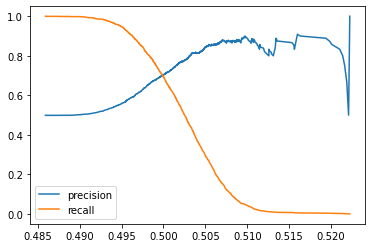

In [13]:
plt.plot(threshold,precision[:-1], label="precision")
plt.plot(threshold,recall[:-1], label="recall")
plt.legend()

## <a id='8'><center><font color="INDIANRED">8) Confirmation du modèle</font></center></a>

In [38]:
X_test

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,DAYS_INSTALLMENT_LATE,PAYMENT_DISCREPANCY,SK_ID_CURR_CNT_BUREAU,SK_ID_CURR_CNT_CRED_CARD,SK_ID_CURR_CNT_POS_CASH,SK_ID_CURR_CNT_INSTALL
9394,0,1,0,1,1,90000.0,513531.0,24835.5,459000.0,7,...,-1397.0,-1404.0,5126.464,4189.6655,7.773,936.79834,1.00,37.28,30.00,31.00
898,0,0,0,0,0,193500.0,715095.0,55341.0,675000.0,7,...,-352.5,-364.0,16057.485,16057.4850,11.540,0.00000,3.00,3.00,16.00,13.00
2398,0,1,0,1,1,202500.0,229500.0,15336.0,229500.0,7,...,-741.0,-747.0,10679.688,10679.6880,6.200,0.00000,5.00,37.28,14.00,10.00
5906,0,0,0,0,0,121500.0,348264.0,19993.5,315000.0,7,...,-454.0,-460.0,22008.902,22008.9020,6.110,0.00000,5.55,37.28,20.00,18.00
2343,0,0,0,1,0,157500.0,834048.0,25285.5,720000.0,7,...,-910.5,-922.0,18382.863,18743.9430,11.190,-363.19232,4.00,37.28,29.52,39.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4142,0,0,0,0,0,90000.0,653328.0,21204.0,468000.0,7,...,-1046.0,-1050.0,11513.032,12254.9660,3.707,-741.93370,5.00,37.28,81.00,89.00
2067,0,0,1,0,0,112500.0,128092.5,9706.5,103500.0,7,...,-313.0,-316.0,9987.323,9987.3230,2.889,0.00000,12.00,37.28,19.00,18.00
768,0,0,0,1,0,81000.0,517500.0,25024.5,517500.0,7,...,-579.5,-584.0,14386.373,13869.2840,4.473,517.08840,2.00,35.00,42.00,116.00
5927,0,0,0,0,0,67500.0,339241.5,12919.5,238500.0,1,...,-910.5,-922.0,18382.863,18743.9430,11.190,-363.19232,3.00,37.28,29.52,39.84


In [39]:
reg_loaded2 = pickle.load(open('model_adaboost.pkl', 'rb'))

In [40]:
reg_loaded2

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('selectkbest', SelectKBest(k=12))])),
                ('adaboostclassifier', AdaBoostClassifier(random_state=0))])

In [41]:
result2 = reg_loaded2.predict(X_test)

In [42]:
result2

array([1, 0, 0, ..., 0, 1, 0], dtype=int64)

In [43]:
df_demise = pd.read_csv('./df_train.csv')
df_demise

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,DAYS_INSTALLMENT_LATE,PAYMENT_DISCREPANCY,SK_ID_CURR_CNT_BUREAU,SK_ID_CURR_CNT_CRED_CARD,SK_ID_CURR_CNT_POS_CASH,SK_ID_CURR_CNT_INSTALL
0,1,0,1,0,1,0,202500.0,406597.5,24700.5,351000.0,...,-295.00000,-315.42105,11559.2470,11559.2470,20.421053,0.00000,8.00000,37.280347,19.0,19.0
1,0,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,-1378.16000,-1385.36000,64754.5860,64754.5860,7.200000,0.00000,4.00000,37.280347,28.0,25.0
2,0,1,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,-754.00000,-761.66670,7096.1550,7096.1550,7.666666,0.00000,2.00000,37.280347,4.0,3.0
3,0,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,-252.25000,-271.62500,62947.0900,62947.0900,19.375000,0.00000,5.55152,6.000000,21.0,16.0
4,0,0,1,0,1,0,121500.0,513000.0,21865.5,513000.0,...,-1028.60610,-1032.24240,12666.4440,12214.0600,3.636364,452.38434,1.00000,37.280347,66.0,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310330,0,0,1,0,0,0,157500.0,254700.0,27558.0,225000.0,...,-120.00000,-156.28572,7492.9243,7492.9243,36.285713,0.00000,5.55152,37.280347,9.0,7.0
310331,0,0,0,0,1,0,72000.0,269550.0,12001.5,225000.0,...,-2391.00000,-2393.66670,10069.8670,10069.8670,2.666667,0.00000,5.55152,37.280347,7.0,6.0
310332,0,0,0,0,1,0,153000.0,677664.0,29979.0,585000.0,...,-2373.00000,-2387.71440,4399.7080,4115.9150,14.714286,283.79250,4.00000,37.280347,17.0,14.0
310333,1,0,0,0,1,0,171000.0,370107.0,20205.0,319500.0,...,-142.26315,-161.26315,10239.8320,10239.8320,19.000000,0.00000,1.00000,37.280347,20.0,19.0


In [44]:
df_notarget = df_demise.drop('TARGET',axis=1)

In [45]:
df_notarget.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,DAYS_INSTALLMENT_LATE,PAYMENT_DISCREPANCY,SK_ID_CURR_CNT_BUREAU,SK_ID_CURR_CNT_CRED_CARD,SK_ID_CURR_CNT_POS_CASH,SK_ID_CURR_CNT_INSTALL
0,0,1,0,1,0,202500.0,406597.5,24700.5,351000.0,7,...,-295.0000,-315.42105,11559.247,11559.247,20.421053,0.00000,8.00000,37.280347,19.0,19.0
1,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,1,...,-1378.1600,-1385.36000,64754.586,64754.586,7.200000,0.00000,4.00000,37.280347,28.0,25.0
2,1,1,1,1,0,67500.0,135000.0,6750.0,135000.0,7,...,-754.0000,-761.66670,7096.155,7096.155,7.666666,0.00000,2.00000,37.280347,4.0,3.0
3,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,7,...,-252.2500,-271.62500,62947.090,62947.090,19.375000,0.00000,5.55152,6.000000,21.0,16.0
4,0,1,0,1,0,121500.0,513000.0,21865.5,513000.0,7,...,-1028.6061,-1032.24240,12666.444,12214.060,3.636364,452.38434,1.00000,37.280347,66.0,66.0


In [46]:
df_ntarget = df_notarget[:50000]

In [47]:
df_ntarget

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,DAYS_INSTALLMENT_LATE,PAYMENT_DISCREPANCY,SK_ID_CURR_CNT_BUREAU,SK_ID_CURR_CNT_CRED_CARD,SK_ID_CURR_CNT_POS_CASH,SK_ID_CURR_CNT_INSTALL
0,0,1,0,1,0,202500.0,406597.5,24700.5,351000.0,7,...,-295.0000,-315.42105,11559.2470,11559.2470,20.421053,0.000000,8.00000,37.280347,19.0,19.0
1,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,1,...,-1378.1600,-1385.36000,64754.5860,64754.5860,7.200000,0.000000,4.00000,37.280347,28.0,25.0
2,1,1,1,1,0,67500.0,135000.0,6750.0,135000.0,7,...,-754.0000,-761.66670,7096.1550,7096.1550,7.666666,0.000000,2.00000,37.280347,4.0,3.0
3,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,7,...,-252.2500,-271.62500,62947.0900,62947.0900,19.375000,0.000000,5.55152,6.000000,21.0,16.0
4,0,1,0,1,0,121500.0,513000.0,21865.5,513000.0,7,...,-1028.6061,-1032.24240,12666.4440,12214.0600,3.636364,452.384340,1.00000,37.280347,66.0,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1,0,0,0,0,67500.0,202500.0,10125.0,202500.0,7,...,-403.0000,-414.37500,8222.5650,8222.5650,11.375000,0.000000,2.00000,37.280347,26.0,24.0
49996,0,1,1,1,2,180000.0,474363.0,28795.5,409500.0,7,...,-193.0000,-211.45454,3216.8413,3216.8413,18.454546,0.000000,12.00000,37.280347,11.0,11.0
49997,0,0,1,1,1,202500.0,592560.0,35937.0,450000.0,7,...,-958.8750,-966.50000,17284.8280,28688.1000,7.625000,-11403.270000,1.00000,7.000000,14.0,16.0
49998,0,0,0,1,0,247500.0,1125000.0,37309.5,1125000.0,7,...,-1371.9316,-1376.34190,8888.7740,8888.3260,4.410256,0.448077,11.00000,95.000000,18.0,117.0


In [48]:
result3 = reg_loaded2.predict(df_ntarget)

In [49]:
df_result = pd.DataFrame(result3)

In [50]:
df_result

,0
0,1
1,0
2,0
3,0
4,1
...,...
49995,0
49996,0
49997,0
49998,0


In [51]:
df_result2 = pd.merge(df_result, df_demise[:50000]['TARGET'], left_index=True, right_index=True, how="outer")

In [52]:
df_result2

,0,TARGET
0,1,1
1,0,0
2,0,0
3,0,0
4,1,0
...,...,...
49995,0,0
49996,0,0
49997,0,0
49998,0,0


In [53]:
df_compare = df_result2[df_result2[0] != df_result2['TARGET']]

In [54]:
df_compare

,0,TARGET
4,1,0
12,1,0
15,1,0
16,1,0
20,1,0
...,...,...
49985,1,0
49986,1,0
49991,1,0
49992,0,1


In [55]:
#Error rate
df_compare.shape[0]/df_result2.shape[0] * 100

31.813999999999997

In [56]:
# Load the dataframe from a CSV file
df_json = pd.read_csv('./df_train.csv')
df_json = df_json.drop('TARGET',axis=1)
# Select one random id
random_row = df_json.sample(n=1, random_state=69)

# Convert the row to JSON format and save it to a file
js = random_row.to_json(orient='columns')


In [58]:
import json

In [59]:
with open("cli.json", "w",) as file:
    json.dump(js, file,)

In [60]:
df_json

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,DAYS_INSTALLMENT_LATE,PAYMENT_DISCREPANCY,SK_ID_CURR_CNT_BUREAU,SK_ID_CURR_CNT_CRED_CARD,SK_ID_CURR_CNT_POS_CASH,SK_ID_CURR_CNT_INSTALL
0,0,1,0,1,0,202500.0,406597.5,24700.5,351000.0,7,...,-295.00000,-315.42105,11559.2470,11559.2470,20.421053,0.00000,8.00000,37.280347,19.0,19.0
1,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,1,...,-1378.16000,-1385.36000,64754.5860,64754.5860,7.200000,0.00000,4.00000,37.280347,28.0,25.0
2,1,1,1,1,0,67500.0,135000.0,6750.0,135000.0,7,...,-754.00000,-761.66670,7096.1550,7096.1550,7.666666,0.00000,2.00000,37.280347,4.0,3.0
3,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,7,...,-252.25000,-271.62500,62947.0900,62947.0900,19.375000,0.00000,5.55152,6.000000,21.0,16.0
4,0,1,0,1,0,121500.0,513000.0,21865.5,513000.0,7,...,-1028.60610,-1032.24240,12666.4440,12214.0600,3.636364,452.38434,1.00000,37.280347,66.0,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310330,0,1,0,0,0,157500.0,254700.0,27558.0,225000.0,7,...,-120.00000,-156.28572,7492.9243,7492.9243,36.285713,0.00000,5.55152,37.280347,9.0,7.0
310331,0,0,0,1,0,72000.0,269550.0,12001.5,225000.0,7,...,-2391.00000,-2393.66670,10069.8670,10069.8670,2.666667,0.00000,5.55152,37.280347,7.0,6.0
310332,0,0,0,1,0,153000.0,677664.0,29979.0,585000.0,7,...,-2373.00000,-2387.71440,4399.7080,4115.9150,14.714286,283.79250,4.00000,37.280347,17.0,14.0
310333,0,0,0,1,0,171000.0,370107.0,20205.0,319500.0,7,...,-142.26315,-161.26315,10239.8320,10239.8320,19.000000,0.00000,1.00000,37.280347,20.0,19.0


In [61]:
with open("./cli.json") as mon_fichier:
    data = json.load(mon_fichier)

In [62]:
cli = pd.read_json(data)

In [65]:
ada.predict_proba(cli)

array([[0.5057948, 0.4942052]])

In [163]:
model_fast.predict_proba(cli)

array([[0.50343269, 0.49656731]])

# API

In [66]:
df_concat_api = df_concat.drop('TARGET',axis=1)

In [67]:
df_concat_api

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,DAYS_INSTALLMENT_LATE,PAYMENT_DISCREPANCY,SK_ID_CURR_CNT_BUREAU,SK_ID_CURR_CNT_CRED_CARD,SK_ID_CURR_CNT_POS_CASH,SK_ID_CURR_CNT_INSTALL
0,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,1,...,-1378.0,-1385.0,64754.5860,64754.5860,7.200,0.00000,4.00,37.28,28.00,25.00
1,1,1,1,1,0,67500.0,135000.0,6750.0,135000.0,7,...,-754.0,-761.5,7096.1550,7096.1550,7.668,0.00000,2.00,37.28,4.00,3.00
2,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,7,...,-252.2,-271.5,62947.0900,62947.0900,19.380,0.00000,5.55,6.00,21.00,16.00
3,0,1,0,1,0,121500.0,513000.0,21865.5,513000.0,7,...,-1029.0,-1032.0,12666.4440,12214.0600,3.637,452.38434,1.00,37.28,66.00,66.00
4,0,1,0,1,0,99000.0,490495.5,27517.5,454500.0,6,...,-1264.0,-1238.0,27702.9650,27360.5020,-26.060,342.46158,3.00,37.28,83.00,35.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,1,1,1,0,90000.0,634482.0,20466.0,454500.0,7,...,-342.0,-365.2,18080.4530,18080.4530,23.230,0.00000,2.00,37.28,15.00,13.00
9996,0,1,0,0,0,225000.0,817560.0,29493.0,675000.0,7,...,-1547.0,-1555.0,13035.9470,13035.9470,7.900,0.00000,5.00,37.28,11.00,10.00
9997,1,0,0,0,1,90000.0,180000.0,9000.0,180000.0,7,...,-792.5,-802.5,4904.4243,4904.4243,9.900,0.00000,6.00,37.28,21.00,19.00
9998,0,0,0,1,1,135000.0,720000.0,36891.0,720000.0,7,...,-1337.0,-1341.0,32446.8240,30214.7460,4.520,2232.07700,5.55,37.28,77.00,75.00
